# Learned Decoder
The purpose of this notebook is to investigate whether we can learn the MURA decoder

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import DataLoader
# from torchsummary import summary
# import sklearn
import wandb

desktop_path = '/Users/jornelasmunoz/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
laptop_path = '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
if desktop_path in sys.path[0]: sys.path.insert(0, desktop_path + 'lib/'); path = desktop_path
elif laptop_path in sys.path[0]: sys.path.insert(0, laptop_path + 'lib/'); path = laptop_path
print('Using path = ', path)

from dataset import MNIST_MURA


# # Change plotting parameters
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Times", #"Computer Modern Serif"
#     "figure.figsize" : [15,10],
# })

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Log into WandB
# wandb.login()

Using path =  /Users/jornelasmunoz/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/
Using cpu device


In [3]:
class Noise_dB(object):
    '''
    Given a desired Signal to Noise Ratio (in decibels, dB)
    returns a noisy image
    
    Inputs:
        desired_snr: Integer. Signal to noise ration in decibels 
    '''

    def __init__(self, desired_snr=10):
        super().__init__()
        self.snr = desired_snr

    def __call__(self, tensor):
         # Calculate the variance of the image pixels
        signal_power = torch.var(tensor)
    
        # Calculate the noise power
        noise_power = signal_power / (10**(self.snr/10))
    
        # Generate random noise matrix
        noise = torch.normal(0,torch.sqrt(noise_power), size=tensor.shape)
    
        # Add the noise to the image
        noisy_image = tensor + noise
        # noisy_image = torch.clip(noisy_image, 0, 1)

        return noisy_image

    def __repr__(self):
        return self.__class__.__name__ + '(snr = {0})'.format(self.snr)

# class Noise(object):
#     def __init__(self, mean=0, dev=1):
#         self.mean = mean
#         self.dev = dev
    
#     def __call__(self, tensor):
#         return tensor + torch.randn(tensor.size())*self.dev + self.mean
    
#     def __repr__(self):
#         return self.__class__.__name__ + 'mean = {0}, dev= {1}', format(self.mean, self.dev)

In [4]:
# Log into WandB
wandb.login()

wandb: Currently logged in as: jocelynornelasmunoz. Use `wandb login --relogin` to force relogin


True

In [5]:
# Create params dict
params = {
    "image_size": 23,
    "batch_size":100,
    "learning_rate": 0.001, 
    "epochs": 20,
    "model": "decoder_cnn",
    "dataset": "mnist_mura_noiseless",
    "scheduler_patience": 2,
    "snr": 10, 
}
wandb.config = params

In [6]:
# Define transforms
transform_list = transforms.Compose(
            [   transforms.Grayscale(),
                transforms.ToTensor(),
                transforms.Resize(params['image_size'], antialias=True),
                Noise_dB(desired_snr=params['snr']),
                # Noise(mean=0,dev=params['noise_std']),
                transforms.Normalize(0, 1),
                ])
target_transform = transforms.Compose(
            [   transforms.Grayscale(),
                transforms.ToTensor(),
                transforms.Resize((params['image_size'],params['image_size']), antialias=True),
                ])

In [7]:
# Load dataset
mnist_mura = MNIST_MURA('../data/MNIST/', params, transform=transform_list, target_transform=target_transform, train=True)

loaders = {}
# Define DataLoader
loaders['train'] = DataLoader(mnist_mura, batch_size=1, shuffle=False)

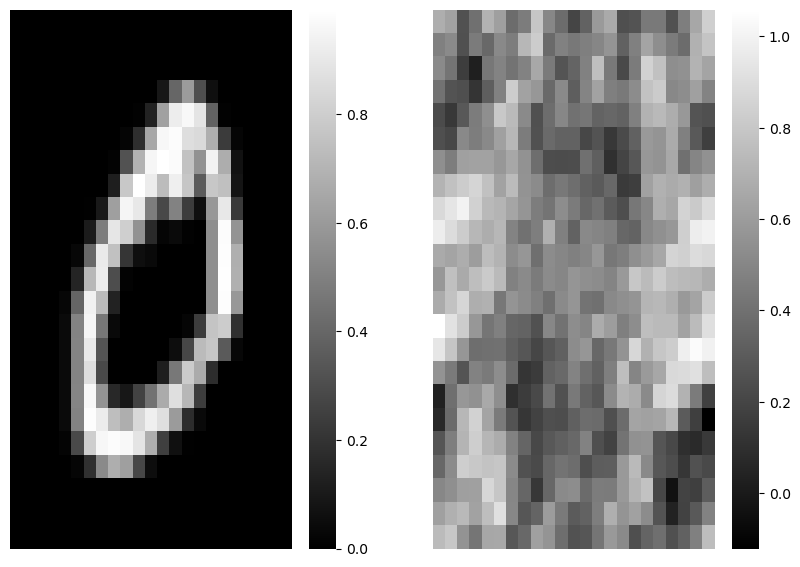

In [8]:
fig, axs = plt.subplots(1,2, figsize=(10,7))
idx=1
sns.heatmap(loaders['train'].dataset[idx]['target'].squeeze(0), cmap= 'gray', ax=axs[0])
sns.heatmap(loaders['train'].dataset[idx]['img'].squeeze(0), cmap= 'gray', ax=axs[1])
axs[0].axis('off')
axs[1].axis('off')
plt.show()

# Define Model

In [9]:
class RECON_CNN(torch.nn.Module):
    '''
    Define a model with only one convolutional layer and sigmoid activation function
    '''
    def __init__(self, params):
        super().__init__() 
        
        # Define model basic info
        self.params = params
        self.img_size = self.params['image_size']
        self.kernel_size = self.params['image_size'] if self.params['image_size'] is not None else self.params['kernel_size']
        self.params["kernel_size"] = self.kernel_size
        self.criterion = torch.nn.MSELoss() if self.params.get('loss') is None else torch.nn.L1Loss() #
        self.params['model_save_path'] = f'../models/learned_decoder_cnn/{params["model"]}.pth'
        
        # Define model architecture elements
        self.conv  = torch.nn.Conv2d(1,1,kernel_size=self.kernel_size, padding='same', padding_mode='circular')#(self.kernel_size-1)//2)
        print("Using the following parameters:")
        for key, val in self.params.items():
            print(f"{key}: {val}")
        
    def forward(self, x):
        if "activation" in self.params['model']:
            output = torch.sigmoid(self.conv(x))
        else:
            # 03.20.23 Trying out a model with no activation function -- update 03.28.23 Didnt work if it's just no activation :( 
            # 04.12.23 Trying no activation function with l_1 penalty
            #output = self.conv(x)
            
            # Trying convolution transpose as test
            output = self.conv(x)
        return output

In [10]:
# Instantiate model 
model = RECON_CNN(params)#.to(device)
model.optimizer = torch.optim.Adam(model.parameters(), lr = model.params['learning_rate']) #torch.optim.SGD(model.parameters(), lr = model.params['learning_rate'])
model.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model.optimizer, 'min',patience=model.params['scheduler_patience'])

Using the following parameters:
image_size: 23
batch_size: 100
learning_rate: 0.001
epochs: 20
model: decoder_cnn
dataset: mnist_mura_noiseless
scheduler_patience: 2
snr: 10
kernel_size: 23
model_save_path: ../models/learned_decoder_cnn/decoder_cnn.pth


# Training

In [12]:
%%time
import datetime
# Initialize project in Weights and Biases
wandb.init(config=wandb.config, 
           project="ca-learned-decoder", 
           group="cnn", 
           name=str(datetime.datetime.now()))

# Store values for later 
train_loss = []
# val_loss = []
frob_per_epoch = []
weights_epoch = {}

#Dictionary that will store different images and outputs for various epochs (not sure if needed)
outputs = {}

# Training loop starts
for epoch in range(params['epochs']):
    
    # Initialize variable to store loss
    running_loss = 0
    model.train()
    # Iterate over training set
    for i, data in enumerate(loaders['train']):
        # zero the parameter gradients
        model.optimizer.zero_grad()
        
        # get the inputs; data is a dict of [images, labels, digit]
        inputs, targets, digits = data['img'], data['target'], data['digit']
            
        # Generate output
        out = model(inputs)
        
        # Calculate loss
        loss = model.criterion(out, targets)
        
        # # Modified (04/06/23) to include l_1 penalty
        # l_1_pen = sum((w.abs()-1).abs().sum() for w in model.parameters())
        # loss = loss + (model.params['lambda']/(model.params['p']**2)) * l_1_pen

        
        # Backprop and update weights
        loss.backward()
        model.optimizer.step()
        
        # Increment loss
        running_loss += loss.item()
        
        # Add table to wandb
        # test_table.add_data(i, wandb.Image(inputs[0]), out[0], wandb.Image(targets[0]), digits[0])
    # Average loss over entire dataset
    running_loss/= len(loaders['train'].dataset)#params['batch_size']
    train_loss.append(running_loss)

    # Scheduler step every epoch
    model.scheduler.step(loss)
    
    print(f"Epoch {epoch +1} | Loss: {running_loss:.7f}")
    wandb.log({"epoch": epoch, "loss": running_loss, }) #"table":test_table
    
    # Storing images, reconstructed outputs, and labels
    outputs[epoch+1] = {'img': inputs, 'out': out, 'targets': targets, 'digits': digits}
    
    # Save weights every 10 epochs
    if epoch % 2 == 1:
        torch.save(model.state_dict(), model.params['model_save_path'])
        # epoch_save_model = path+f'models/CNN/{params["model"]}_model_epoch_'+str(epoch)+'.pth'
        # torch.save(model.state_dict(),epoch_save_model)
        weight_epoch_list = list(model.parameters())
        weights_epoch[f'{epoch}'] = np.squeeze(weight_epoch_list[0].detach().cpu().numpy())
        

    # Calculate Frobenius norm between weights and decoder every epoch
    weights = list(model.parameters())
    weight_map = np.squeeze(weights[0].detach().cpu().numpy())
    diff_block = mnist_mura.G - weight_map
    frob_per_epoch.append(np.linalg.norm(np.abs(diff_block),ord='fro'))

#torch.save(model.state_dict(), PATH)
# End WandB run
wandb.finish()

Epoch 1 | Loss: 0.0075974
Epoch 2 | Loss: 0.0069826
Epoch 3 | Loss: 0.0069563
Epoch 4 | Loss: 0.0069478
Epoch 5 | Loss: 0.0069438
Epoch 6 | Loss: 0.0069417
Epoch 7 | Loss: 0.0069405
Epoch 8 | Loss: 0.0069397
Epoch 9 | Loss: 0.0069392
Epoch 10 | Loss: 0.0040756
Epoch 11 | Loss: 0.0040766
Epoch 12 | Loss: 0.0040766
Epoch 13 | Loss: 0.0040766
Epoch 14 | Loss: 0.0037508
Epoch 15 | Loss: 0.0037495
Epoch 16 | Loss: 0.0037495
Epoch 17 | Loss: 0.0037495
Epoch 18 | Loss: 0.0037839
Epoch 19 | Loss: 0.0037824
Epoch 20 | Loss: 0.0037822


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▇▇▇▇▇▇▇▂▂▂▂▁▁▁▁▁▁▁
epoch,19
loss,0.00378


CPU times: user 8min 15s, sys: 2min 46s, total: 11min 2s
Wall time: 8min 26s


# Load model

In [11]:
model.load_state_dict(torch.load('../models/learned_decoder_cnn/decoder_cnn.pth'))

<All keys matched successfully>

In [12]:
weight_map = list(model.parameters())[0].cpu().detach().squeeze(0).squeeze(0)

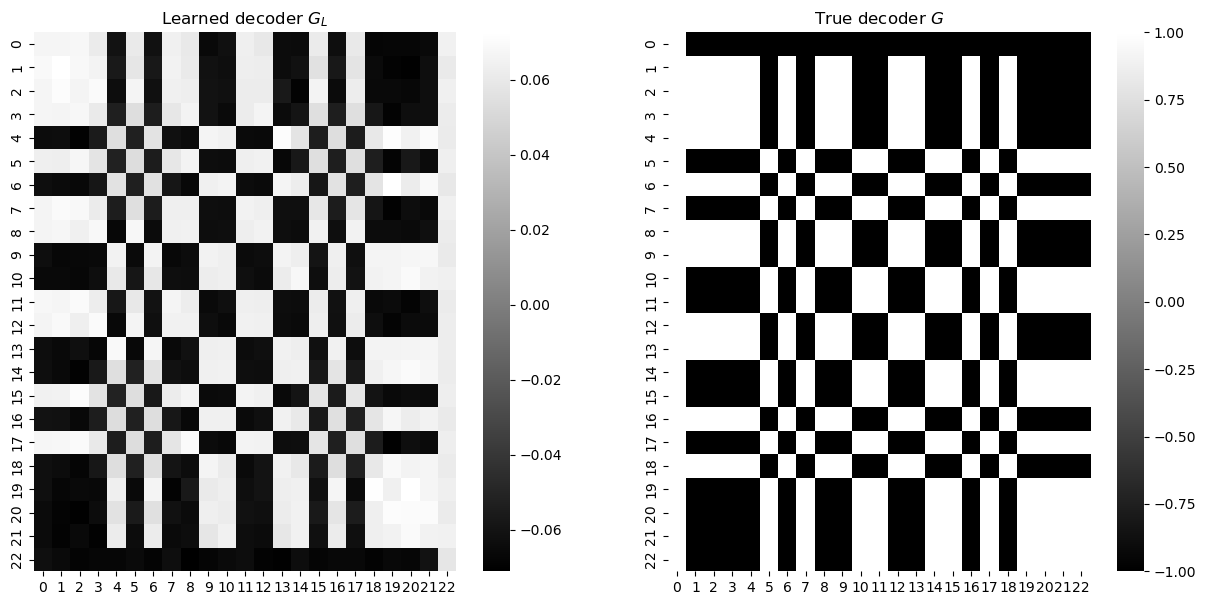

In [13]:
fig, axs = plt.subplots(1,2, figsize = (15,7))
sns.heatmap(weight_map, cmap='gray', ax=axs[0])
sns.heatmap(mnist_mura.G, cmap='gray', ax=axs[1])

axs[0].set_title("Learned decoder $G_L$")
axs[1].set_title("True decoder $G$")
# fig.savefig('../figs/learned_decoder_cnn_20_epochs_circular_pad.png')

plt.show()

# Test set evaluation

In [14]:
from torchmetrics.image import StructuralSimilarityIndexMeasure 

In [15]:
SSIM = StructuralSimilarityIndexMeasure()

In [16]:
# Define test set
test_mnist_mura = MNIST_MURA('../data/MNIST/', params, transform=transform_list, target_transform=target_transform, train=False)
testset = DataLoader(test_mnist_mura, batch_size=10, shuffle=True)

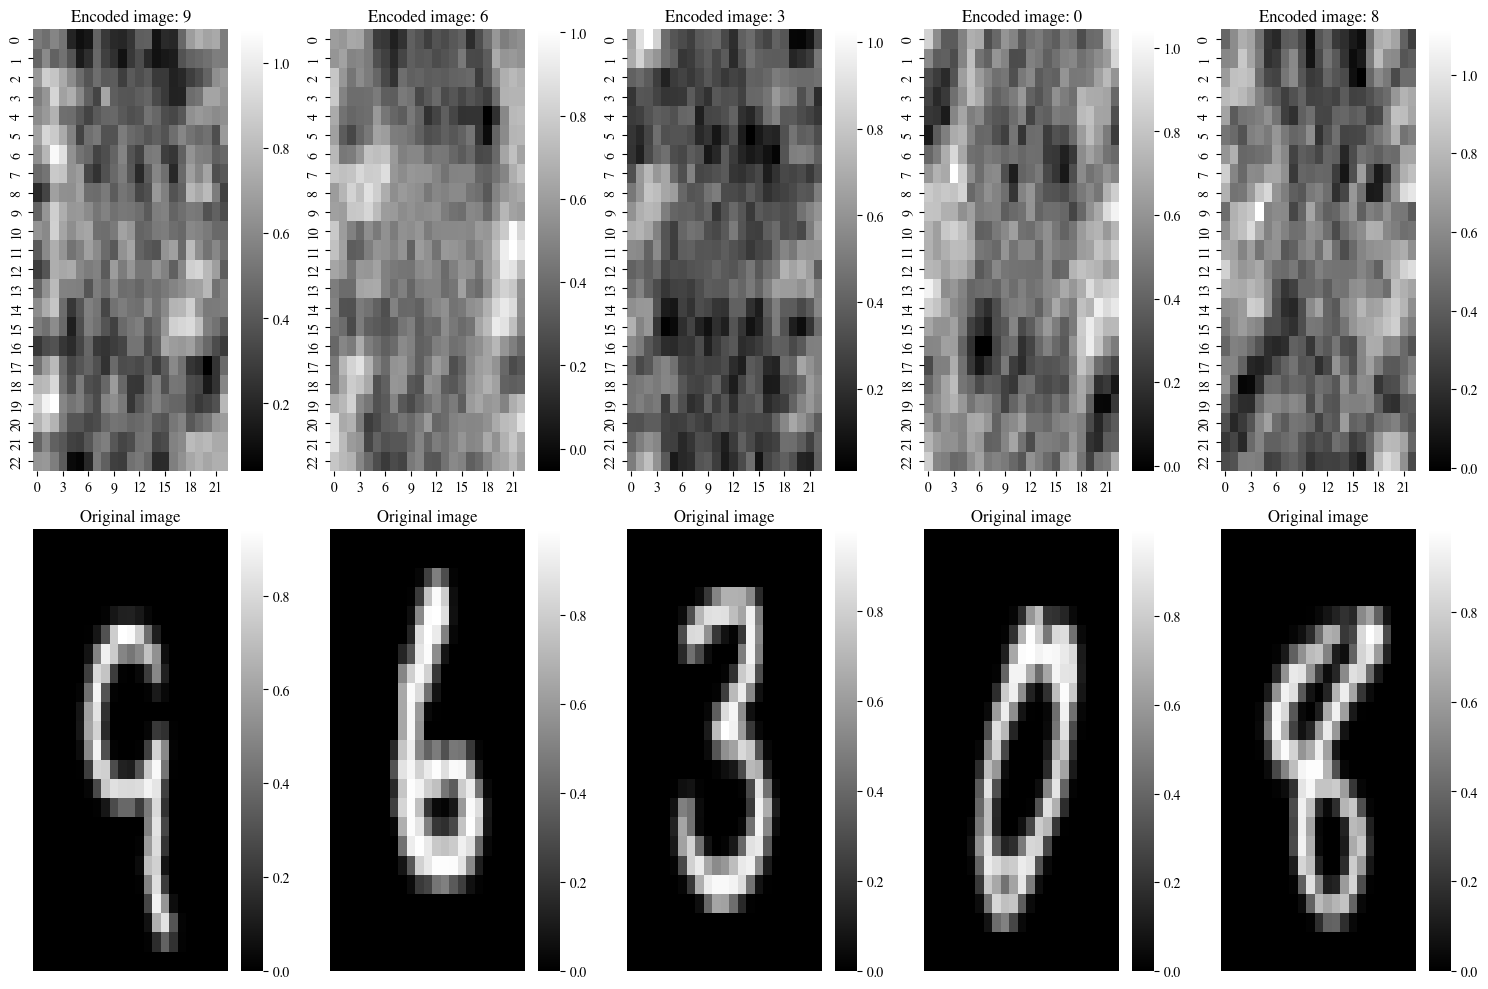

In [17]:
# Change plotting parameters
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Times", #"Computer Modern Serif"
    "figure.figsize" : [15,10],
})
# Printing 25 random images from the training dataset
random_samples = np.random.randint(1, len(testset), (5))
count = 0
for idx in random_samples: #range(random_samples.shape[0]):
    plt.subplot(2, 5, count + 1)
    sns.heatmap(testset.dataset[idx]['img'].squeeze(0), cmap='gray')
    plt.title(f'Encoded image: {testset.dataset[idx]["digit"]}')
    plt.subplot(2, 5, count + 6)
    sns.heatmap(testset.dataset[idx]['target'].squeeze(0), cmap='gray')
    plt.title('Original image')
    plt.axis('off')
    
    count += 1
plt.tight_layout()
#plt.savefig("../figs/encoded_original_examples.png")
plt.show()

In [18]:
results = []
for i, data in enumerate(testset):
    inputs, targets, digits = data['img'], data['target'], data['digit']
    outputs = model(inputs.to(device))
    mse_loss = model.criterion(outputs, targets)
    ssim_loss = SSIM(outputs, targets)
    results.append((inputs, outputs, targets, digits, mse_loss.item(), ssim_loss.item()))
    # show_outputs(outputs, targets, inputs, iterator=i)

In [19]:
df = pd.DataFrame(results, columns=['inputs', 'outputs', 'targets', 'digits', 'mse', 'ssim'])

In [20]:
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
# pio.renderers.default = 'notebook'

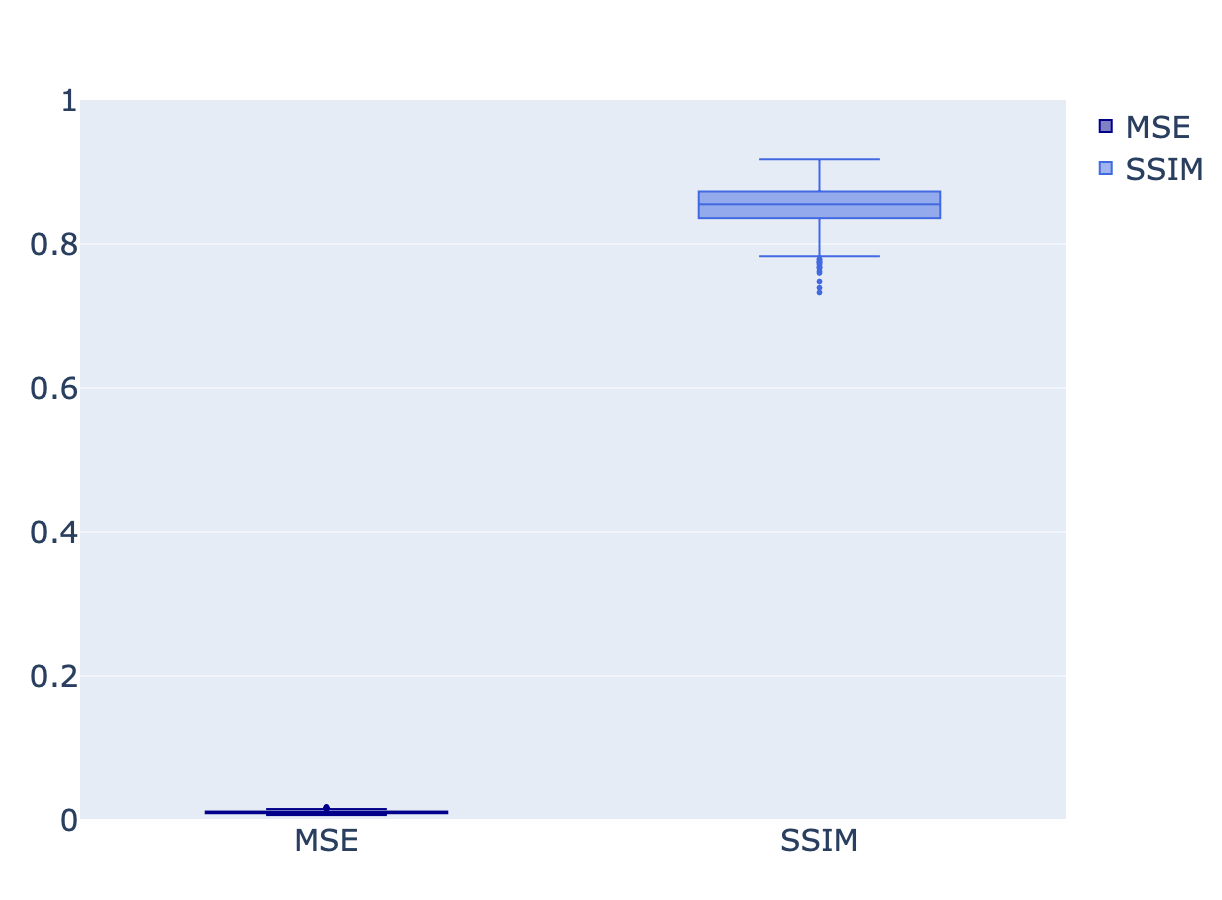

In [21]:
y0 = df.mse
y1 = df.ssim

fig = go.Figure()
fig.add_trace(go.Box(y=y0, name='MSE',
                marker_color = 'darkblue'))
fig.add_trace(go.Box(y=y1, name = 'SSIM',
                marker_color = 'royalblue'))
fig.update_layout(
    autosize=False,
    width=1200,
    height=900,
    yaxis=dict(
        # title_text="Y-axis Title",
        # ticktext=["Very long label", "long label", "3", "label"],
        # tickvals=,
        tickmode="array",
        titlefont=dict(size=30),
    ),
    yaxis_range=[0,1],
    font=dict(size=30),
)
fig.show(renderer="jupyterlab")
# fig.write_image('../figs/learned_decoder_cnn_mse_SSIM.png')

# Rotate the weights

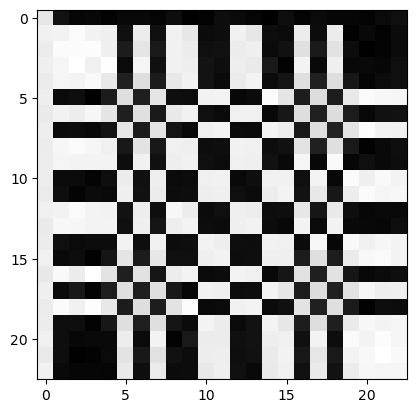

In [42]:
# Rotate the weights 180 degrees
w_rot90 = torch.rot90(torch.Tensor(weight_map), 1, [0, 1])
w_rot180 = torch.rot90(w_rot90, 1, [0, 1])
plt.imshow(w_rot180, cmap='gray')

In [28]:
padded_ex = torch.nn.functional.pad(loaders['train'].dataset[idx]['target'].unsqueeze(0), pad=(11,11,11,11), mode='circular')
padded_ex = padded_ex.squeeze(0).squeeze(0)

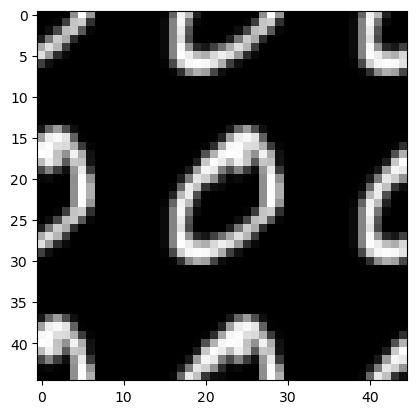

In [34]:
plt.imshow(padded_ex, cmap='gray')
plt.show()